In [1]:
%matplotlib notebook

In [26]:
import numpy as np
import flammkuchen as fl
from matplotlib import pyplot as plt
from bouter import FreelySwimmingExperiment
from glob import glob
from scipy.signal import medfilt
from scipy.ndimage.filters import generic_filter
from scipy.stats import zscore
from pathlib import Path
import pandas as pd

In [3]:
# take last deceleration chunk around do the mean between the points at the beginning and at the end of the chunck and then
# do the arctang

In [4]:
def extract_segments_above_threshold(trace, threshold=0.1, min_length=20, min_between=25, break_segment_on_nan=True):

    segments = []
    in_segment = False
    start = 0
    connected = []
    continuity = False

    # we start at the first possible time to detect the threshold crossing
    # (because the pad_before period has to be always included)
    i = 1
    i_last_segment_ended = 0
    while i < trace.shape[0] - min_between:

        # 3 cases where the state can change
        # we encountered a NaN (breaks continuity)
        if np.isnan(trace[i]):
            continuity = False
            if in_segment and break_segment_on_nan:
                in_segment = False
        # segment has ended and a positive threshold crossing has been found
        elif (
            i > i_last_segment_ended
            and trace[i - 1] < threshold < trace[i]
            and not in_segment
        ):
            in_segment = True
            start = i
        # a negative threshold crossing has been found while
        # we are inside a segment:
        elif trace[i - 1] > threshold > trace[i] and in_segment:
            in_segment = False
            if i - start > min_length:
                segments.append((start, i))
                i_last_segment_ended = i + min_between
                if continuity:
                    connected.append(True)
                else:
                    connected.append(False)
                continuity = True

        # in all other cases the state cannot change

        i += 1

    return np.array(segments), np.array(connected)

In [5]:
def points_to_angles(points):
    angles = np.empty(len(points) - 1, dtype=np.float64)
    for i, (p1, p2) in enumerate(zip(points[0:-1], points[1:])):
        angles[i] = np.arctan2(p2[1] - p1[1], p2[0] - p1[0])
    return angles

In [6]:
def interpolate_nans(X):
    mask_j = np.isnan(X)
    X[mask_j] = np.interp(np.flatnonzero(mask_j), np.flatnonzero(~mask_j), X[~mask_j])
    return X

In [6]:
data_stytra = fl.load(r"\\FUNES\Shared\experiments\E0041_temperature\WT_check_summer_poa\v00_no_stimulus\220809_f0\180442_behavior_log.hdf5")['data']

In [7]:
exp = FreelySwimmingExperiment(r"\\FUNES\Shared\experiments\E0041_temperature\WT_check_summer_poa\v00_no_stimulus\220809_f0")

In [8]:
exp["stimulus"]["calibration_params"]["mm_px"] = 0.1
exp["stimulus"]["calibration_params"]["cam_to_proj"] = np.eye(2)

In [9]:
vel = exp.compute_velocity()

In [10]:
vel = vel['vel2_f0']

In [11]:
bouts_stytra, _= extract_segments_above_threshold(vel,
                                                 threshold=10, min_length=3, min_between=10, break_segment_on_nan=True)

<IPython.core.display.Javascript object>


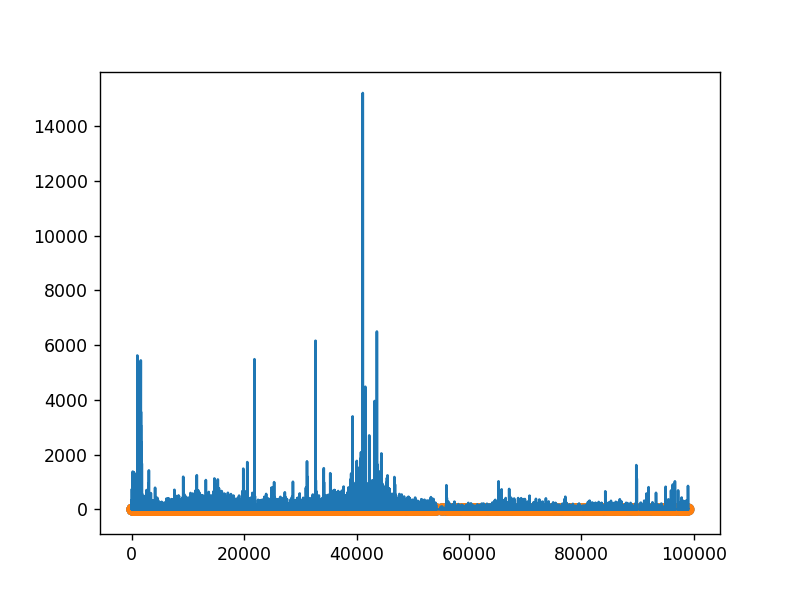

In [44]:
plt.figure()
plt.plot(vel)
plt.scatter(bouts_stytra[:,0],[5]*bouts_stytra.shape[0])
plt.scatter(bouts_stytra[:,1],[5]*bouts_stytra.shape[0])
plt.show()

In [12]:
x_stytra = interpolate_nans(generic_filter(data_stytra['f0_x'].values,np.nanmean,3))
y_stytra = interpolate_nans(generic_filter(data_stytra['f0_y'].values,np.nanmean,3))
dist_stytra = np.sqrt(np.diff(x_stytra)**2 + np.diff(y_stytra)**2)
t_stytra = data_stytra['t']
vel_stytra = dist_stytra/np.diff(t_stytra)

C:\Users\epaoli\anaconda3\lib\site-packages\scipy\ndimage\filters.py:1447: RuntimeWarning: Mean of empty slice
  cval, origins, extra_arguments, extra_keywords)


In [13]:
tp_vect=3
angles = []
for i_bout in range(bouts_stytra.shape[0]):
    start_ = bouts_stytra[i_bout,0]
    end_ = bouts_stytra[i_bout,1]
    crop_pre_bout_x = x_stytra[start_-tp_vect:start_+tp_vect]
    crop_pre_bout_y = y_stytra[start_-tp_vect:start_+tp_vect]
    theta_pre = np.polyfit(crop_pre_bout_x, crop_pre_bout_y, 1)
    y_fitted_pre_0 = theta_pre[1] + theta_pre[0] * crop_pre_bout_x[0]
    y_fitted_pre_1 = theta_pre[1] + theta_pre[0] * crop_pre_bout_x[-1]
    angles_pre_bout = np.arctan2(crop_pre_bout_x[-1] - crop_pre_bout_x[0],
                                 y_fitted_pre_1 - y_fitted_pre_0)

    crop_post_bout_x = x_stytra[end_-tp_vect:end_+tp_vect]
    crop_post_bout_y = y_stytra[end_-tp_vect:end_+tp_vect]
    theta_post = np.polyfit(crop_post_bout_x, crop_post_bout_y, 1)
    y_fitted_post_0 = theta_post[1] + theta_post[0] * crop_post_bout_x[0]
    y_fitted_post_1 = theta_post[1] + theta_post[0] * crop_post_bout_x[-1]
    angles_post_bout = np.arctan2(crop_post_bout_x[-1] - crop_post_bout_x[0],
                                 y_fitted_post_1 - y_fitted_post_0)

    if abs(angles_post_bout-angles_pre_bout)<np.pi:
            to_add = angles_post_bout-angles_pre_bout
    else:
        if (angles_post_bout-angles_pre_bout)>0:

            to_add = (angles_post_bout-np.pi*2)-angles_pre_bout
        else:
            to_add = (angles_post_bout+np.pi*2)-angles_pre_bout
    angles.append(to_add)

In [57]:
print(angles_pre_bout,angles_post_bout,to_add)

0.4204696437135126 -0.2936879617393355 -0.714157605452848


<IPython.core.display.Javascript object>


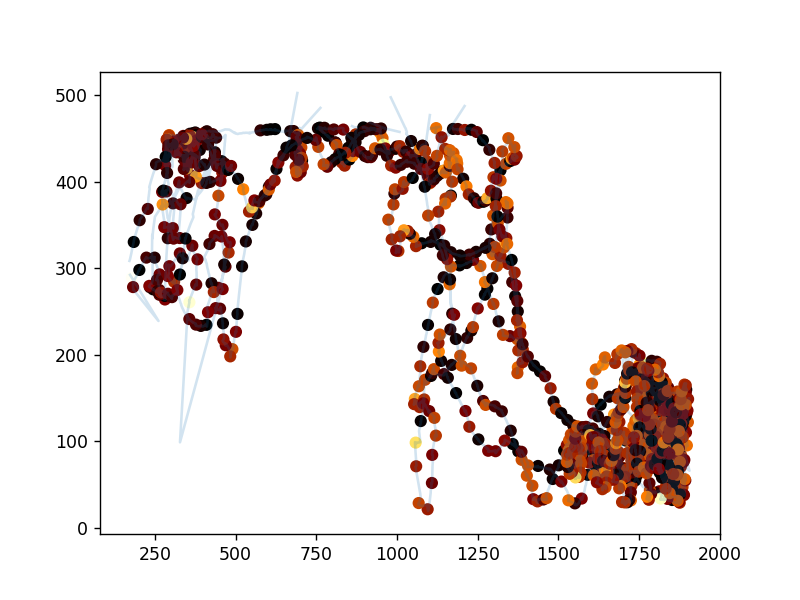

In [14]:
plt.figure()
plt.plot(exp.behavior_log["f0_x"].values[:],exp.behavior_log["f0_y"].values[:],alpha=.2)
plt.scatter(exp.behavior_log["f0_x"].values[bouts_stytra[:,0]],
            exp.behavior_log["f0_y"].values[bouts_stytra[:,0]],c=abs(np.array(angles)),cmap="afmhot")
plt.show()

<IPython.core.display.Javascript object>


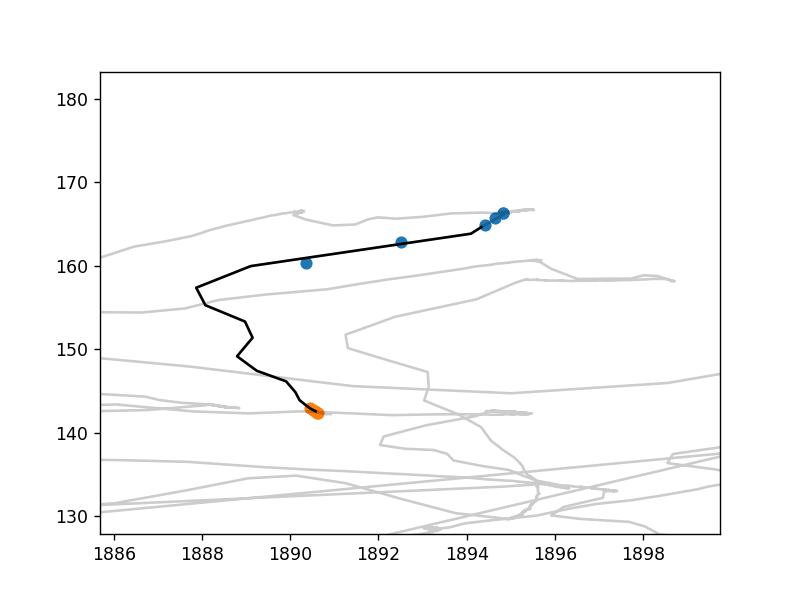

In [15]:
plt.figure()
plt.plot(exp.behavior_log["f0_x"].values[:],exp.behavior_log["f0_y"].values[:],"k",alpha=.2)

plt.plot(exp.behavior_log["f0_x"].values[start_:end_],exp.behavior_log["f0_y"].values[start_:end_],"k")
plt.scatter(crop_pre_bout_x,crop_pre_bout_y)
plt.scatter(crop_post_bout_x,crop_post_bout_y)
plt.show()

## method 2

In [19]:
p1 = np.array([x_stytra[0:-1], y_stytra[0:-1]])
p2 = np.array([x_stytra[1:], y_stytra[1:]])

NameError: name 'x_stytra' is not defined

In [215]:
angles = np.empty(len(x_stytra) - 1)
prev_val = 0
for value in range(p1.shape[1]):
    angle = np.arctan2(p2[1, value] - p1[1, value], p2[0, value] - p1[0, value])
    if abs(angle-prev_val)<np.pi:
        to_add = angle-prev_val
    else:
        if (angle-prev_val)>0:
            
            to_add = (angle-np.pi*2)-prev_val
        else:
            to_add = (angle+np.pi*2)-prev_val
    angles[value] = to_add
    prev_val = angle
    

<IPython.core.display.Javascript object>


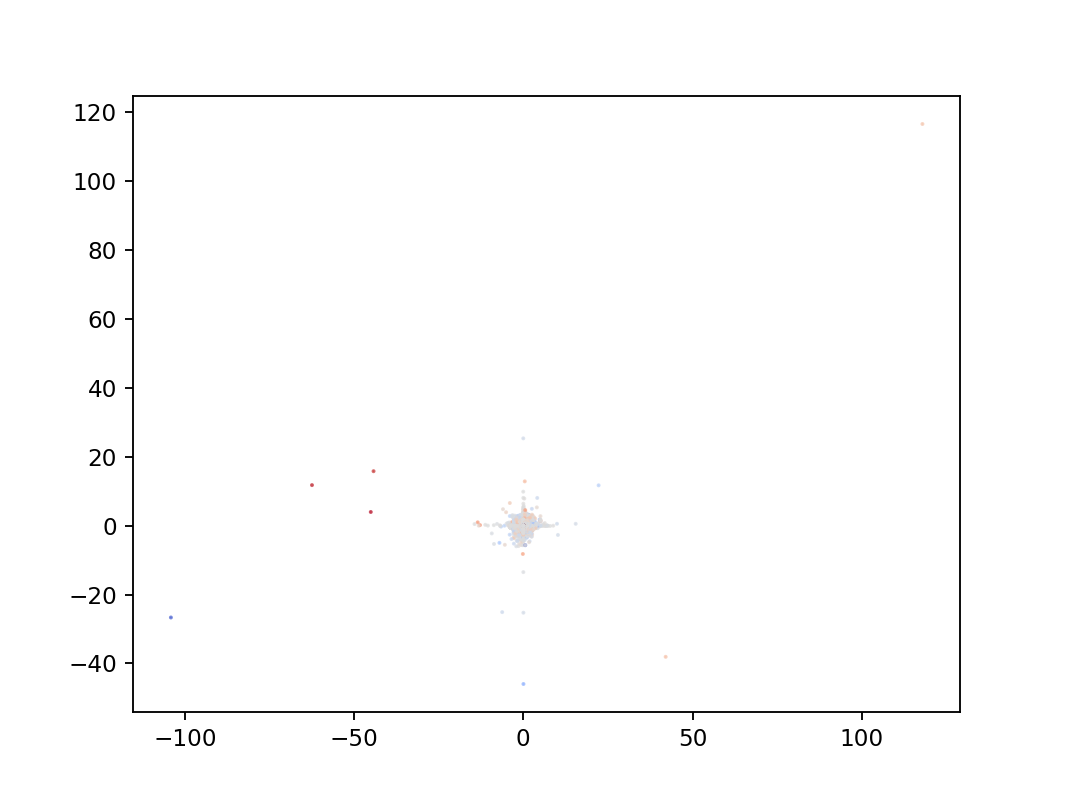

In [189]:
plt.figure()
plt.scatter(p2[0,:]-p1[0,:],
           p2[1,:]-p1[1,:],c=angles,vmin=-np.pi,vmax=np.pi,cmap="coolwarm",
           s=.5, alpha=.7)
plt.show()

<IPython.core.display.Javascript object>


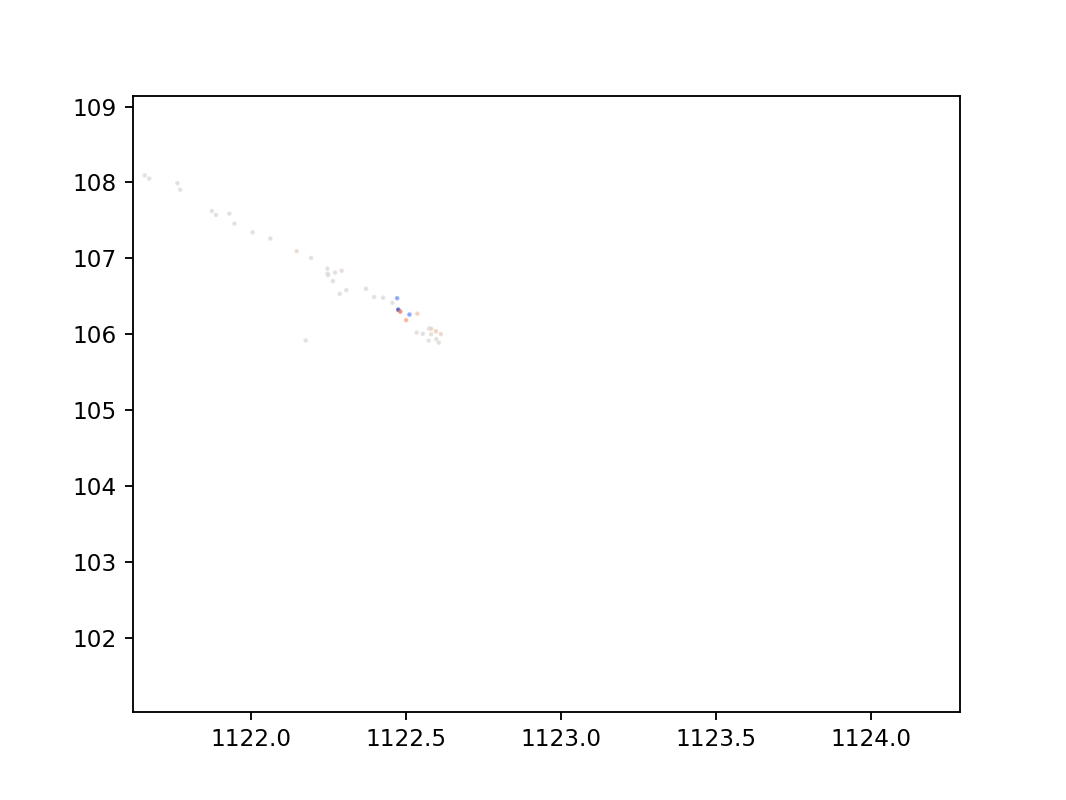

In [209]:
plt.figure()
plt.scatter(data_stytra['f0_x'].values[:-1],data_stytra['f0_y'].values[:-1],c=angles,vmin=-.5,vmax=.5,cmap="coolwarm",
           s=1, alpha=.7)
plt.ylim([80,130])
plt.xlim([1100,1135])
plt.show()

In [200]:
medfilt_angles = medfilt(interpolate_nans(angles), 1)

In [36]:
len(medfilt_angles)

99000

<IPython.core.display.Javascript object>


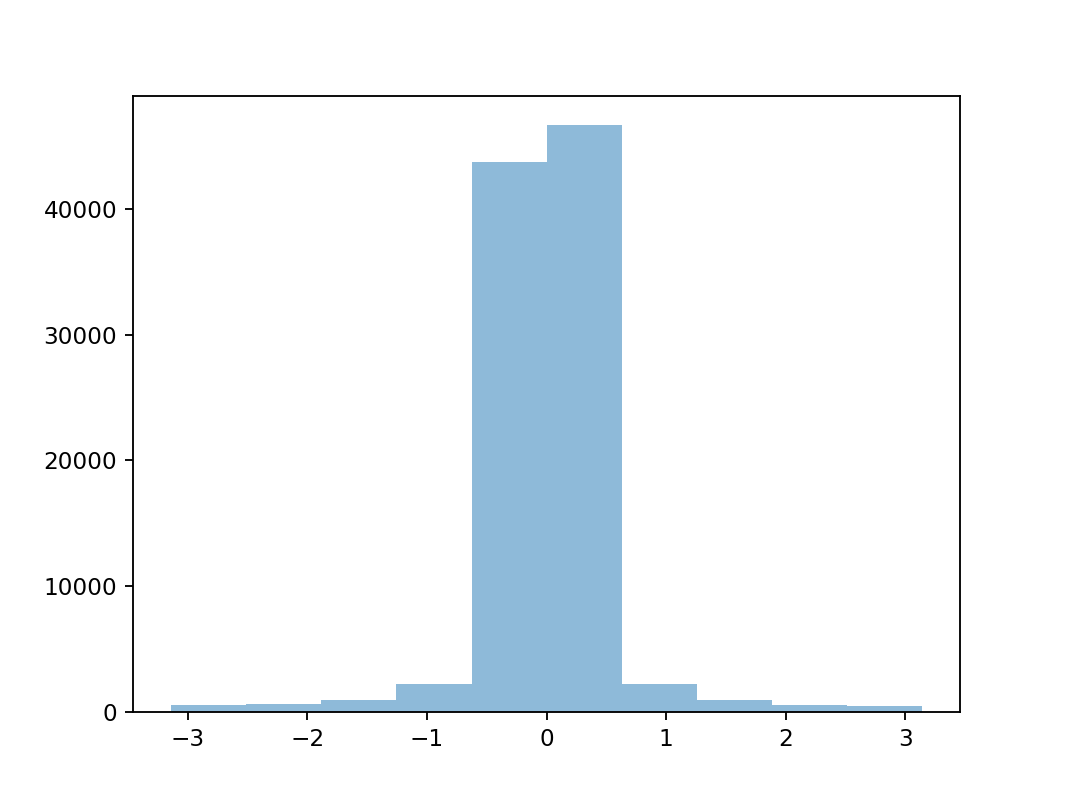

In [212]:
plt.figure()
# plt.hist(medfilt_angles)
plt.hist(angles,alpha=.5)
plt.show()

In [155]:
angles_unwrapped = np.mod(medfilt_angles + np.pi, np.pi * 2) - np.pi

In [163]:
angles_unwrapped1 = np.diff(angles_unwrapped.copy())
angles_unwrapped1 = np.unwrap(angles_unwrapped1[1:] - angles_unwrapped1[0])

<IPython.core.display.Javascript object>


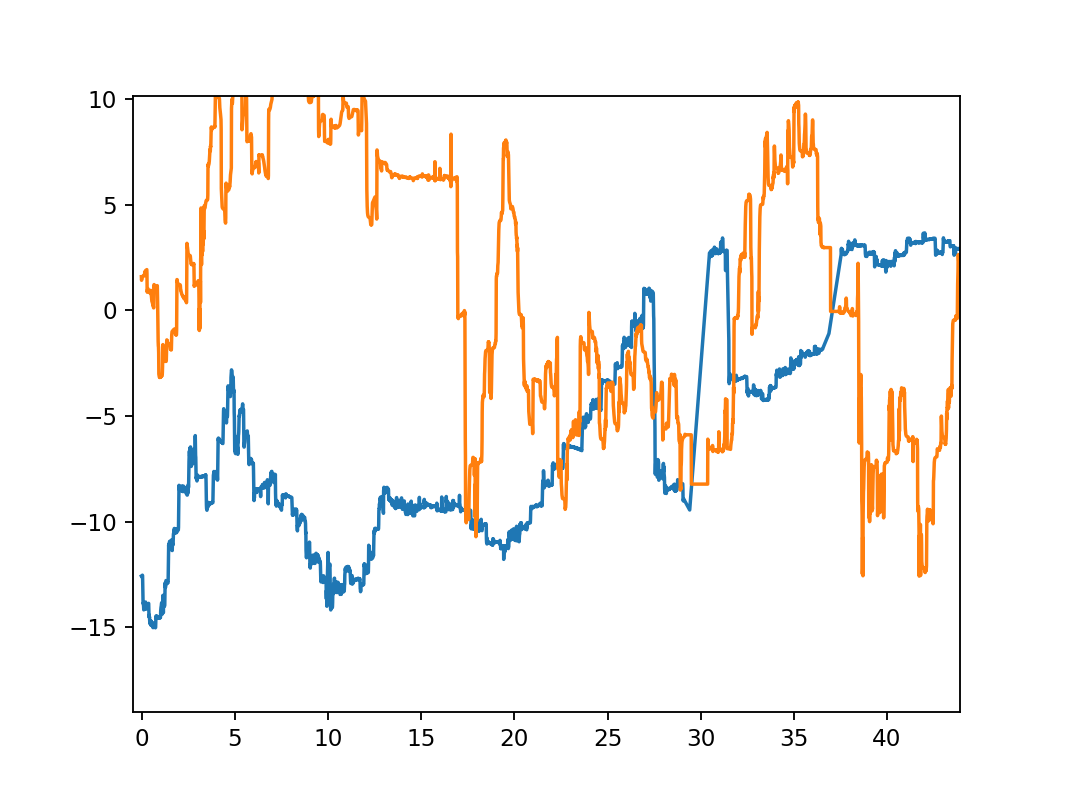

In [217]:
plt.figure()
plt.plot(t_stytra, (data_stytra['f0_theta']))
# plt.plot(t_stytra[:-1], angles_unwrapped)
plt.plot(t_stytra[:-1],medfilt(np.cumsum(angles),1))

plt.show()

<IPython.core.display.Javascript object>


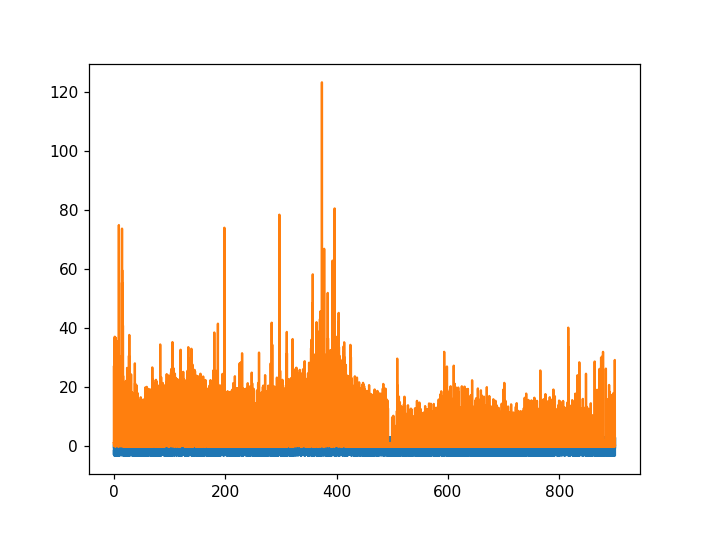

In [44]:
plt.figure()
#plt.plot(t_stytra[:-1], dist_stytra)
plt.plot(t_stytra[:-1], angles)
plt.plot(t_stytra, vel['vel2_f0'])
plt.show()

In [66]:
x_stytra

array([ 349.84942465,  349.70894147,  349.69745735, ..., 1890.86773868,
       1890.90309564, 1890.92035606])

In [11]:
data['DLC_resnet50_SwimmingSep2shuffle1_10000', 'bodypart1']

coords,x,y,likelihood
0,908.053742,265.615585,0.920512
1,908.084813,265.629038,0.906728
2,908.002605,265.721960,0.893414
3,908.101296,265.515202,0.889758
4,908.083662,265.596070,0.889733
...,...,...,...
71997,1126.131917,438.926608,0.988672
71998,1126.103239,438.957499,0.988450
71999,1126.096512,438.936613,0.988426
72000,1126.081827,438.798847,0.989413


<IPython.core.display.Javascript object>


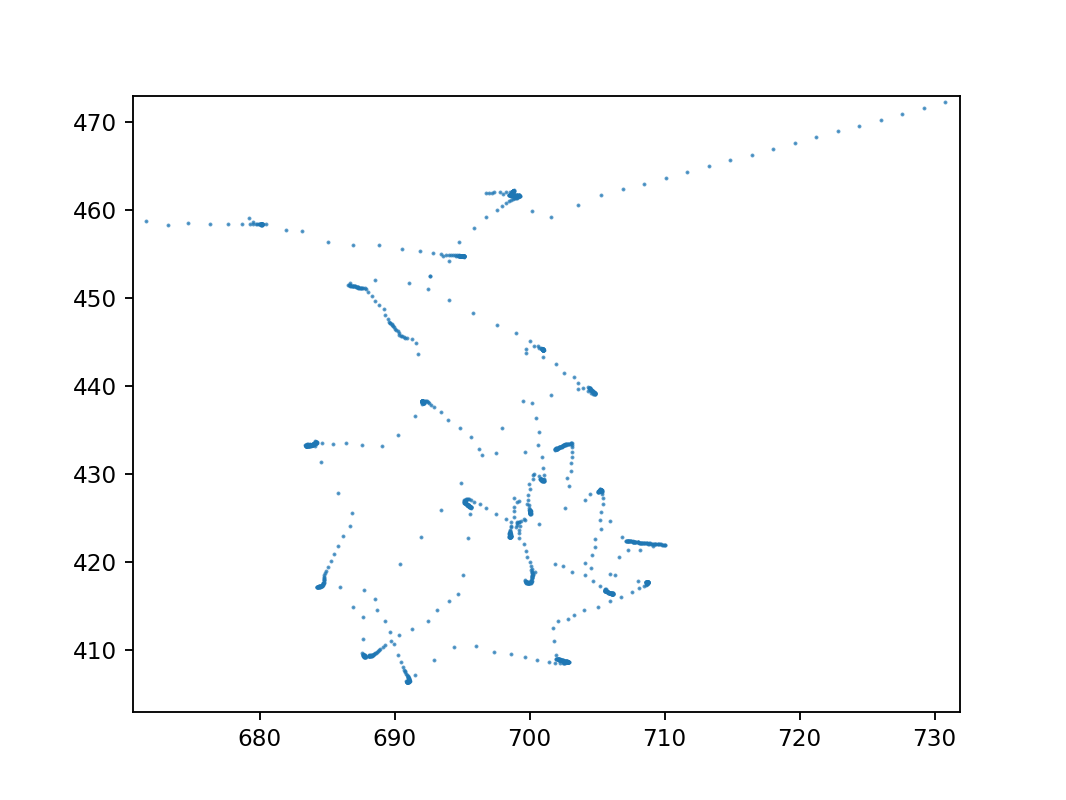

In [19]:
plt.figure()
plt.scatter(data_stytra['f0_x'][:10000], data_stytra['f0_y'][:10000],s=.5, alpha=.7)
plt.show()

In [89]:
x_coord = data['DLC_resnet50_SwimmingSep2shuffle1_10000', 'bodypart1', 'x'].values
y_coord = data['DLC_resnet50_SwimmingSep2shuffle1_10000', 'bodypart1', 'y'].values

In [90]:
dist = np.sqrt(np.diff(x_coord)**2 + np.diff(y_coord)**2) 

In [91]:
fps = 80
px_cm = 0.01


In [92]:
t = data.index.values/fps

In [93]:
t

array([0.000000e+00, 1.250000e-02, 2.500000e-02, ..., 8.999875e+02,
       9.000000e+02, 9.000125e+02])

In [94]:
72000/100

720.0

In [95]:
dist

array([0.03385857, 0.12406735, 0.22910448, ..., 0.02194254, 0.13854569,
       0.00569502])

In [97]:
vel_dlc = dist/(np.diff(t))

In [40]:
#cm
11*0.01 

0.11

In [46]:
2000*0.01

20.0

<IPython.core.display.Javascript object>


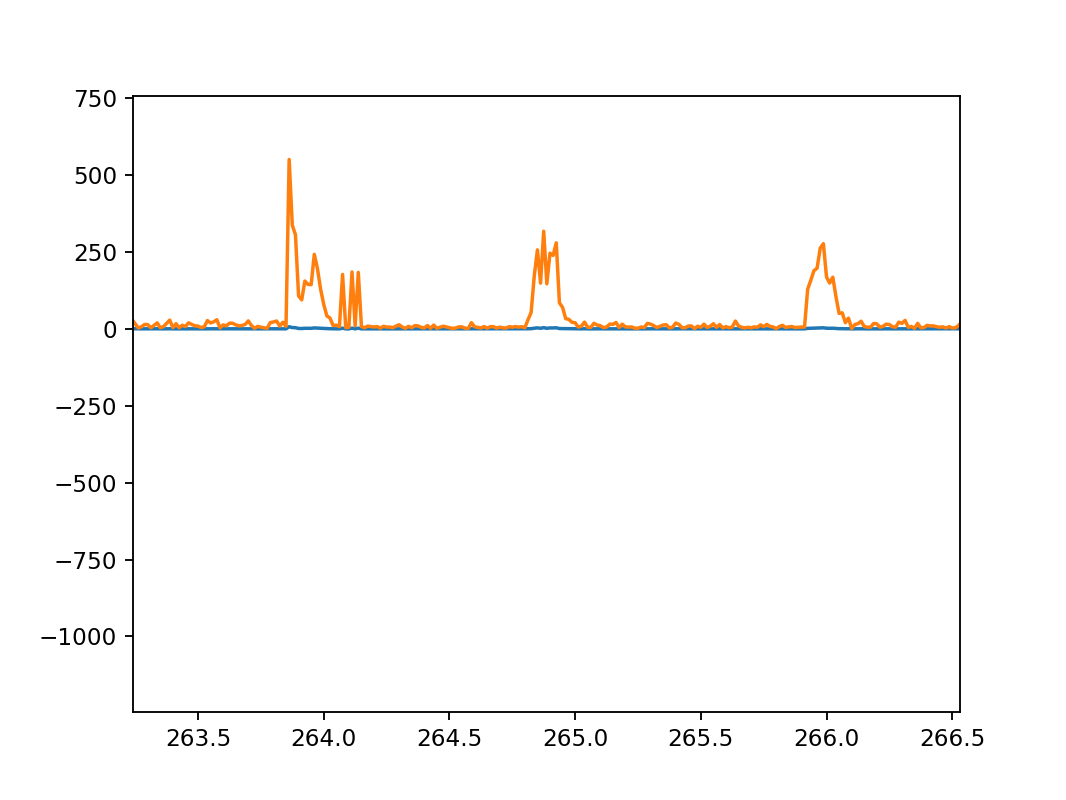

In [63]:
plt.figure()
plt.plot(np.linspace(0, 900, 72001), dist)
plt.plot(np.linspace(0, 900, 72001), vel)
plt.plot
#plt.ylim(0, 30)
plt.show()

<IPython.core.display.Javascript object>


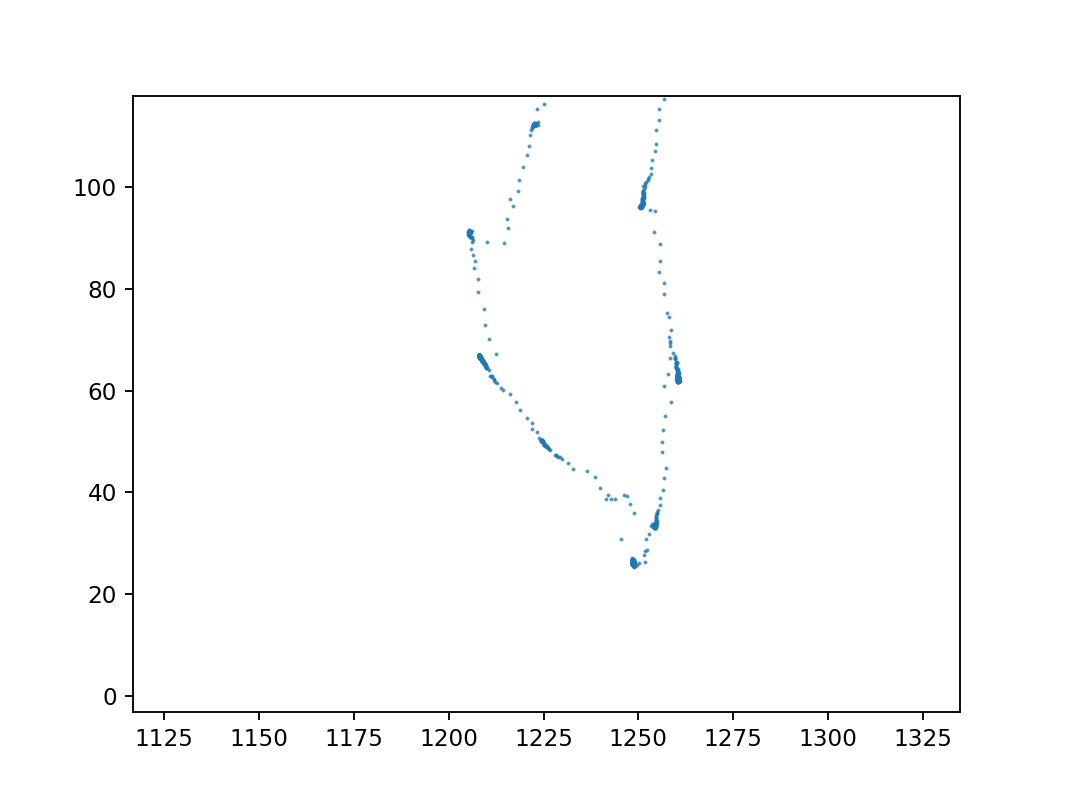

In [18]:
plt.figure()
plt.scatter(data['DLC_resnet50_SwimmingSep2shuffle1_10000', 'bodypart1', 'x'], 
            data['DLC_resnet50_SwimmingSep2shuffle1_10000', 'bodypart1', 'y'], s=.5, alpha=.7)

plt.show()

In [68]:
# Real Data

In [18]:
def extract_theta_bouts(time_bout, x, y,tp_vect=3):
    angles = []
    for i_bout in range(time_bout.shape[0]):
        start_ = time_bout[i_bout,0]
        end_ = time_bout[i_bout,1]
        crop_pre_bout_x = x[start_-tp_vect:start_+tp_vect]
        crop_pre_bout_y = y[start_-tp_vect:start_+tp_vect]
        theta_pre = np.polyfit(crop_pre_bout_x, crop_pre_bout_y, 1)
        y_fitted_pre_0 = theta_pre[1] + theta_pre[0] * crop_pre_bout_x[0]
        y_fitted_pre_1 = theta_pre[1] + theta_pre[0] * crop_pre_bout_x[-1]
        angles_pre_bout = np.arctan2(crop_pre_bout_x[-1] - crop_pre_bout_x[0],
                                     y_fitted_pre_1 - y_fitted_pre_0)

        crop_post_bout_x = x[end_-tp_vect:end_+tp_vect]
        crop_post_bout_y = y[end_-tp_vect:end_+tp_vect]
        theta_post = np.polyfit(crop_post_bout_x, crop_post_bout_y, 1)
        y_fitted_post_0 = theta_post[1] + theta_post[0] * crop_post_bout_x[0]
        y_fitted_post_1 = theta_post[1] + theta_post[0] * crop_post_bout_x[-1]
        angles_post_bout = np.arctan2(crop_post_bout_x[-1] - crop_post_bout_x[0],
                                     y_fitted_post_1 - y_fitted_post_0)

        if abs(angles_post_bout-angles_pre_bout)<np.pi:
                to_add = angles_post_bout-angles_pre_bout
        else:
            if (angles_post_bout-angles_pre_bout)>0:

                to_add = (angles_post_bout-np.pi*2)-angles_pre_bout
            else:
                to_add = (angles_post_bout+np.pi*2)-angles_pre_bout
        angles.append(to_add)
    return np.array(angles)

In [297]:
list_files = list(Path(r"\\FUNES\Shared\experiments\virtual_gradients_experiments\behavior_poa_ablation").glob("*_f*"))

In [91]:
len(list_files)

44

In [229]:
#0
n_fish = 16

<IPython.core.display.Javascript object>


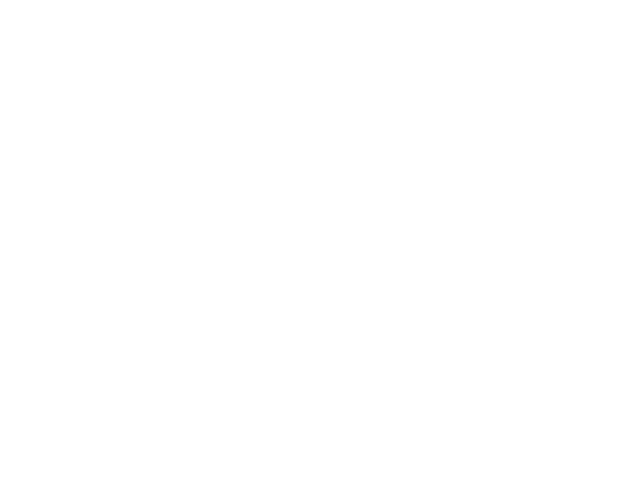

<IPython.core.display.Javascript object>


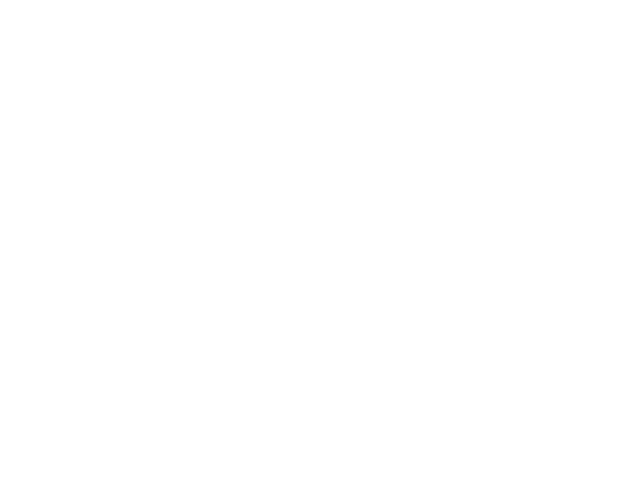

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned


<IPython.core.display.Javascript object>


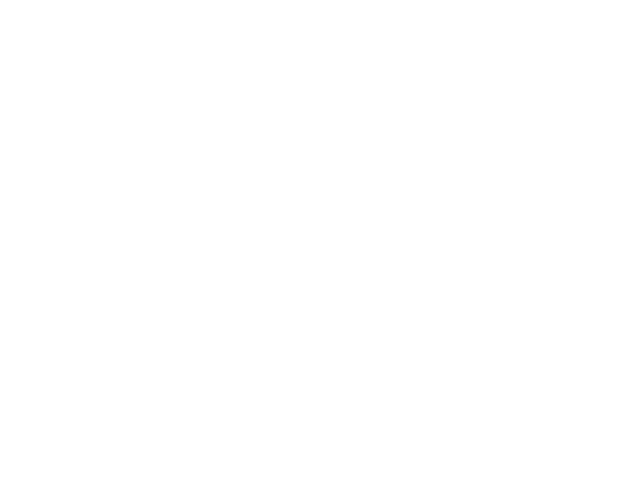

<IPython.core.display.Javascript object>


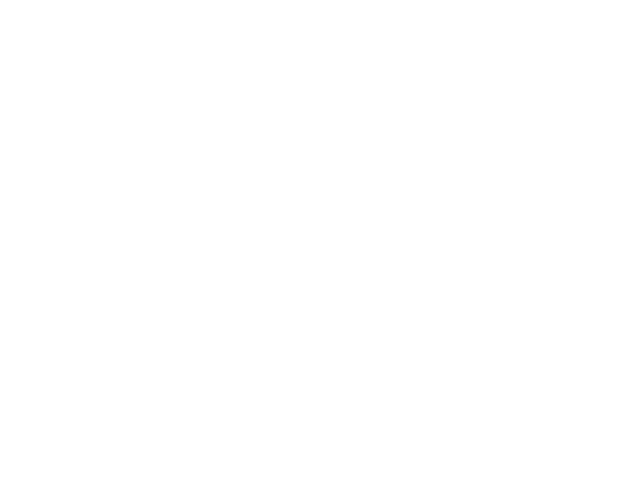

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned


<IPython.core.display.Javascript object>


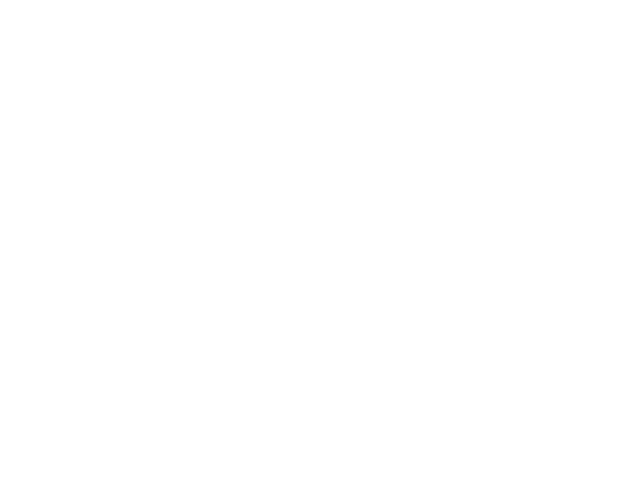

<IPython.core.display.Javascript object>


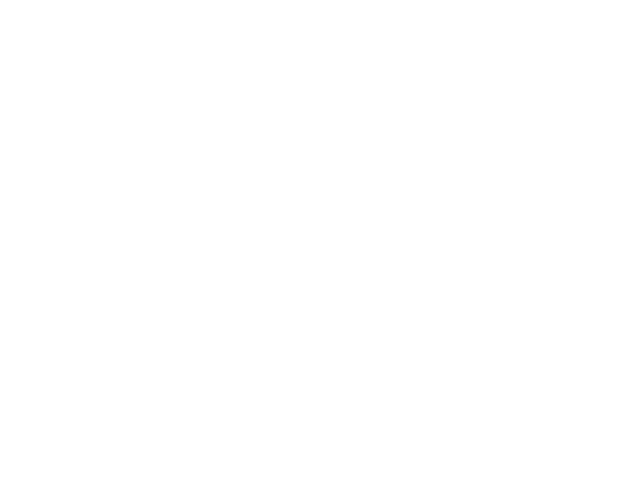

<IPython.core.display.Javascript object>


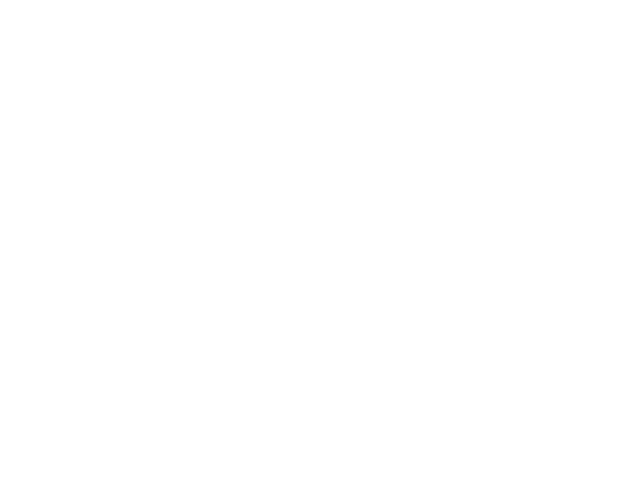

<IPython.core.display.Javascript object>


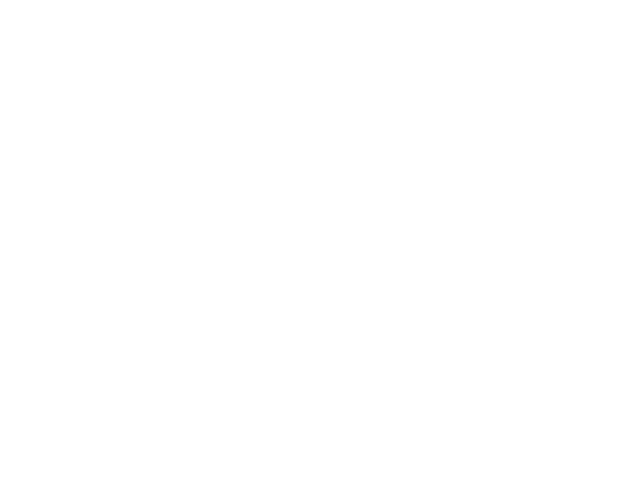

<IPython.core.display.Javascript object>


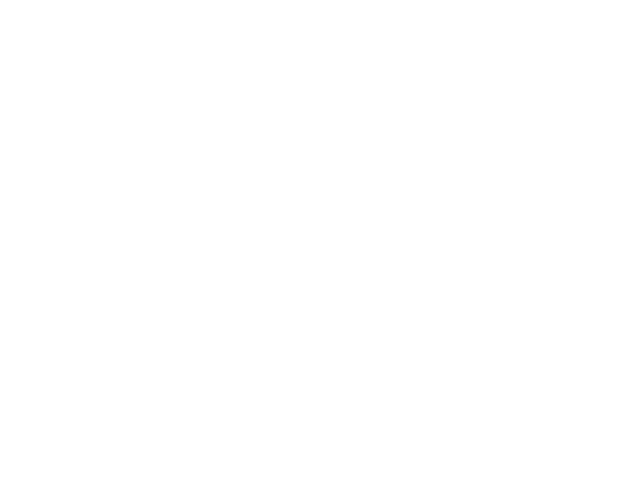

<IPython.core.display.Javascript object>


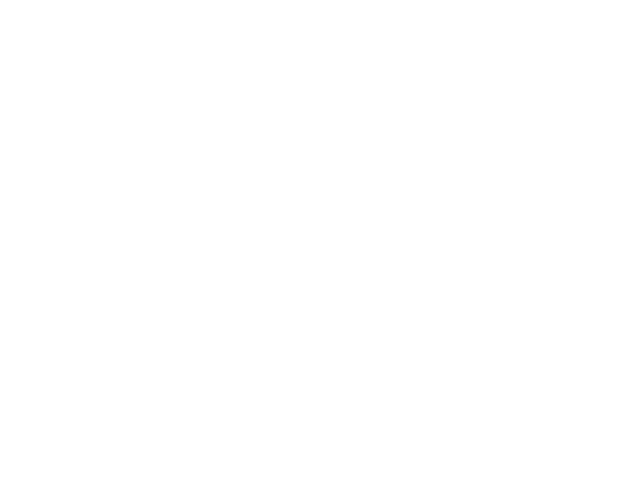

<IPython.core.display.Javascript object>


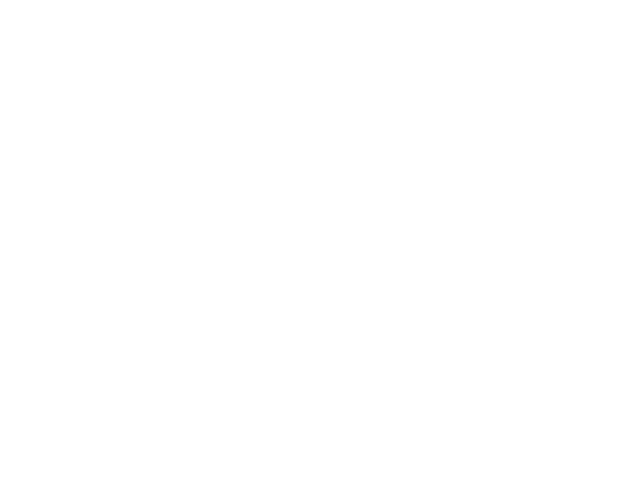

<IPython.core.display.Javascript object>


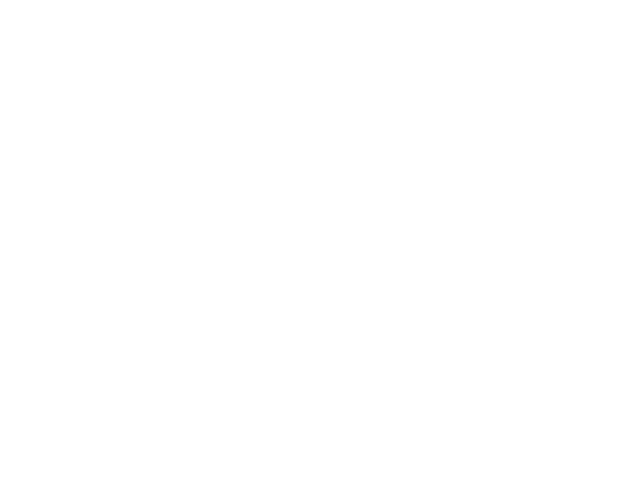

<IPython.core.display.Javascript object>


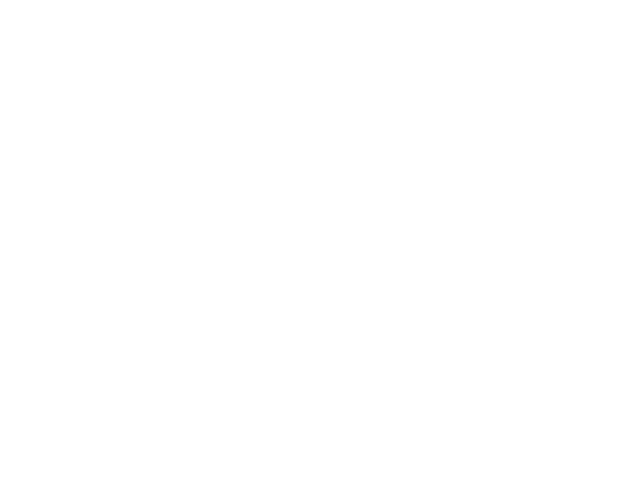

<IPython.core.display.Javascript object>


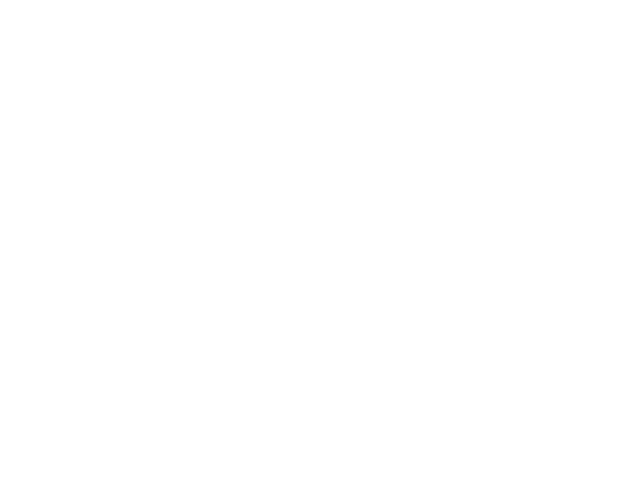

<IPython.core.display.Javascript object>


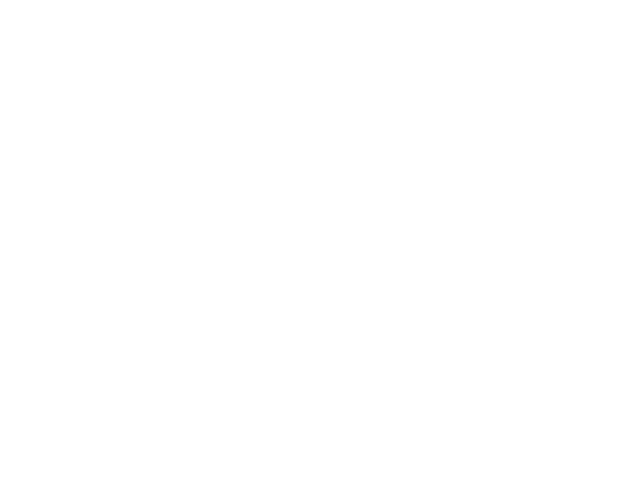

<IPython.core.display.Javascript object>


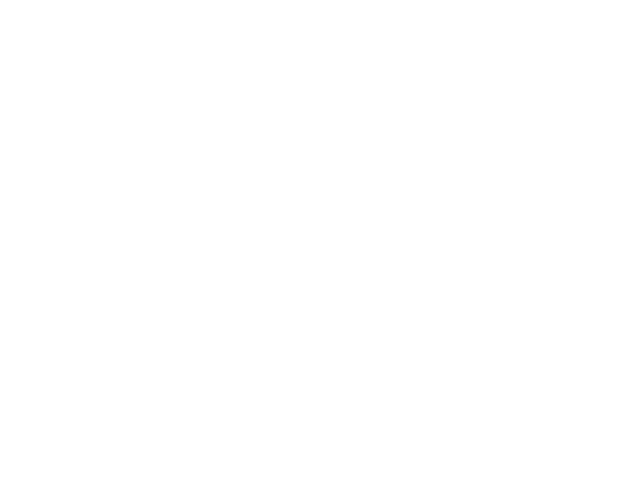

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned


<IPython.core.display.Javascript object>


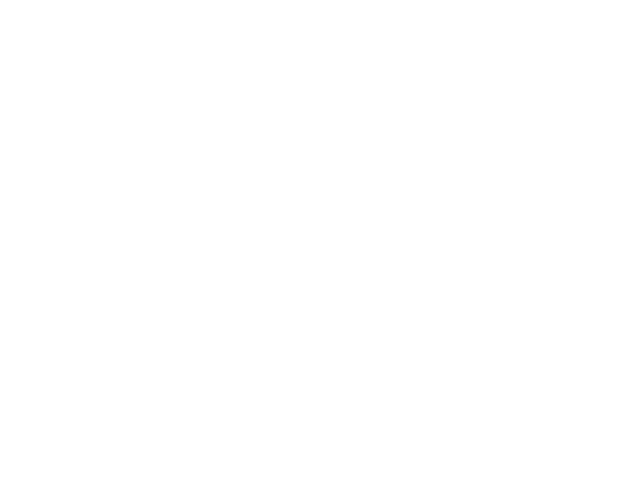

<IPython.core.display.Javascript object>


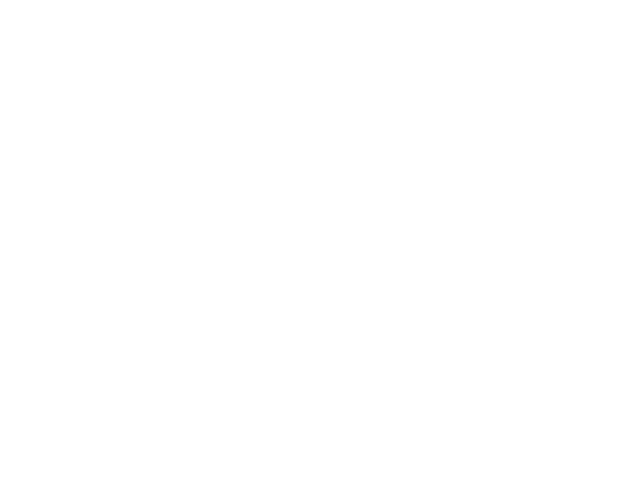

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned


<IPython.core.display.Javascript object>


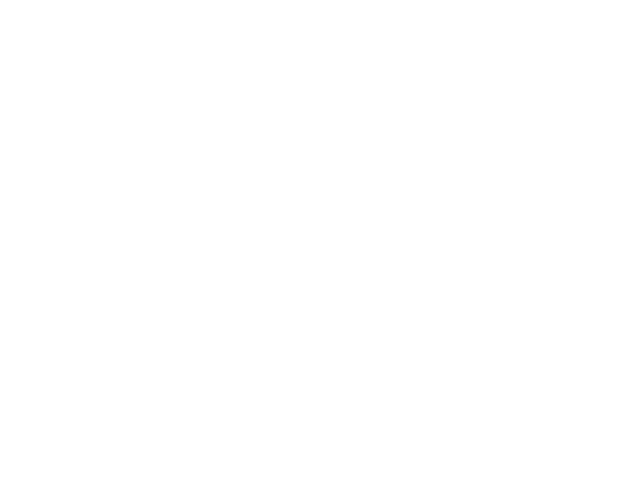

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


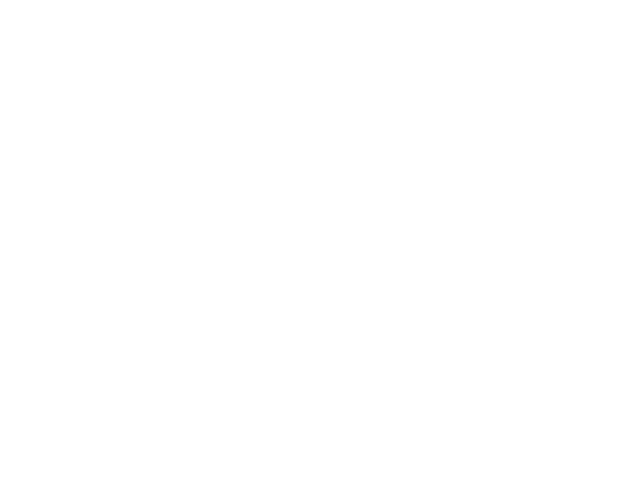

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


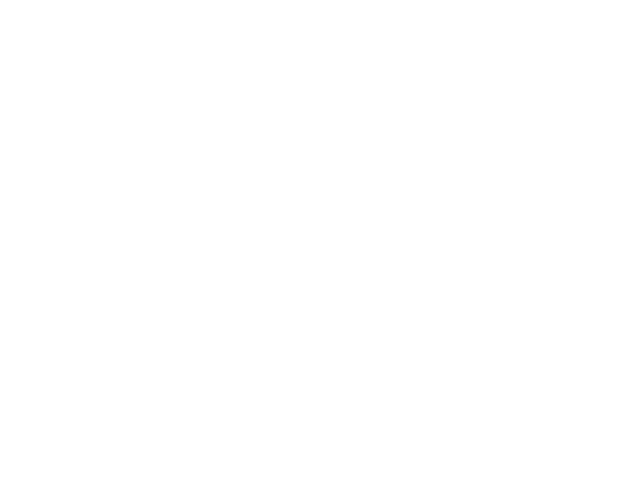

<IPython.core.display.Javascript object>


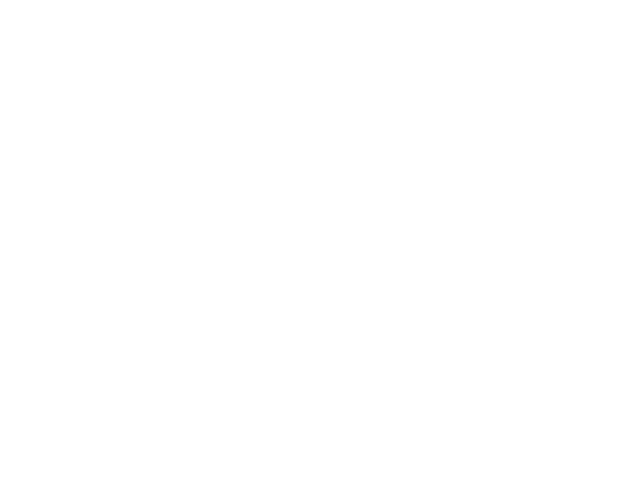

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned


<IPython.core.display.Javascript object>


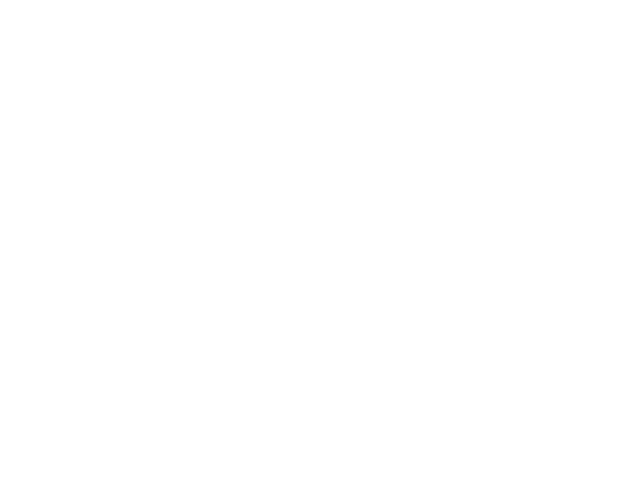

<IPython.core.display.Javascript object>


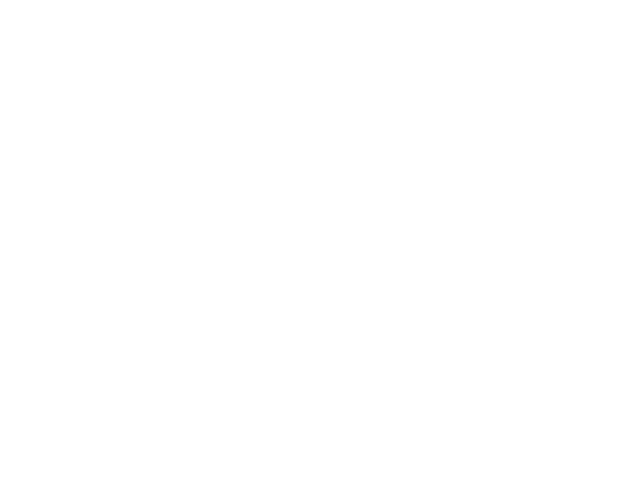

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned


<IPython.core.display.Javascript object>


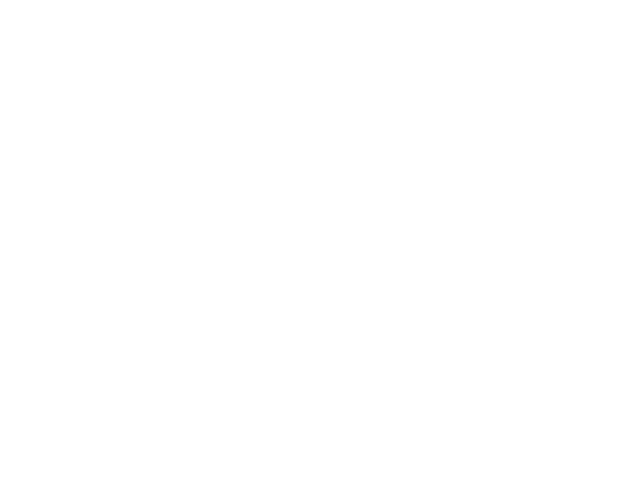

<IPython.core.display.Javascript object>


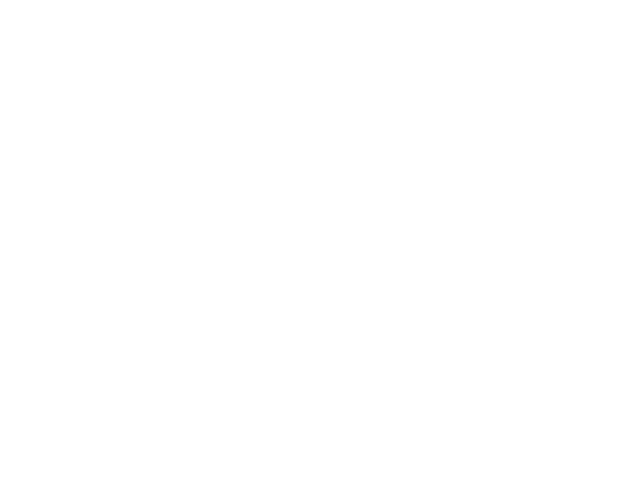

<IPython.core.display.Javascript object>


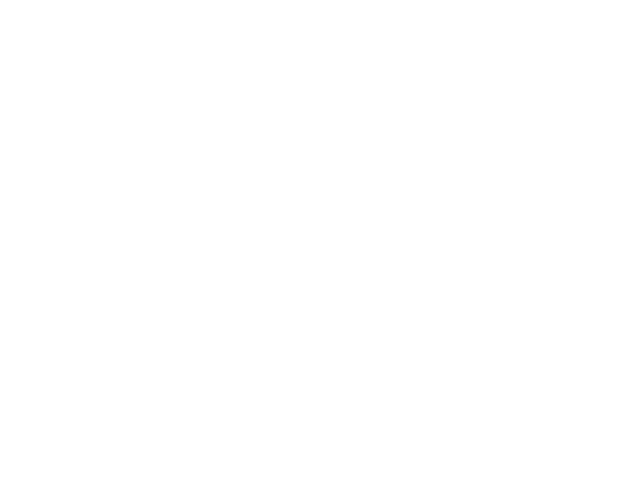

<IPython.core.display.Javascript object>


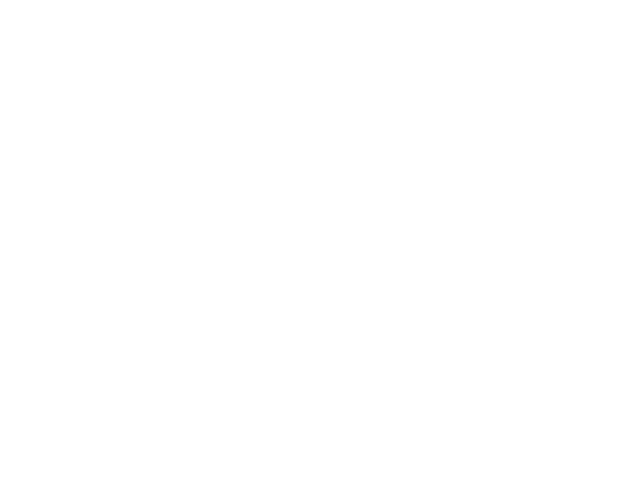

<IPython.core.display.Javascript object>


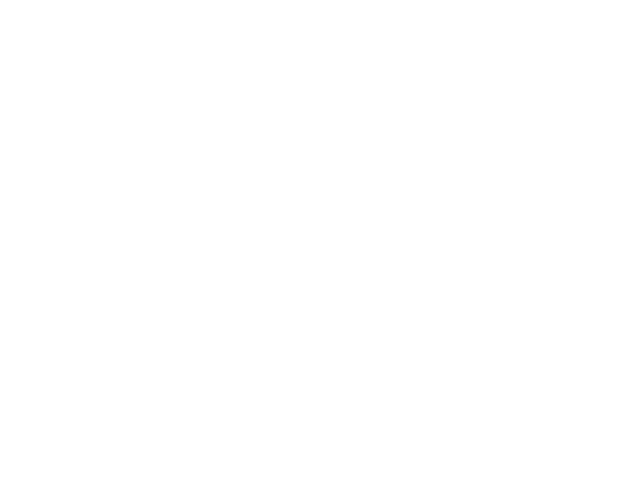

<IPython.core.display.Javascript object>


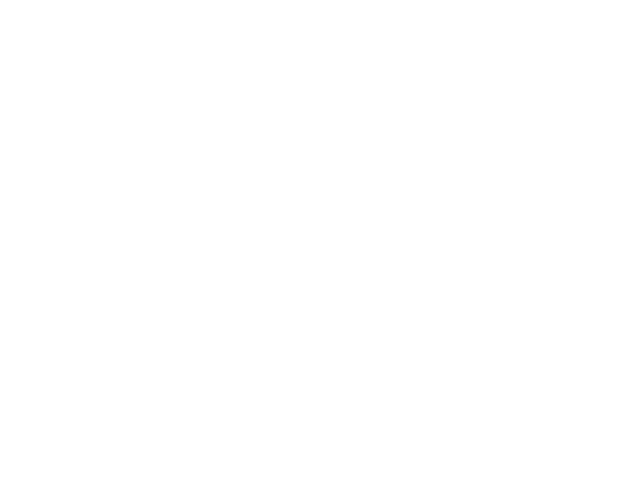

<IPython.core.display.Javascript object>


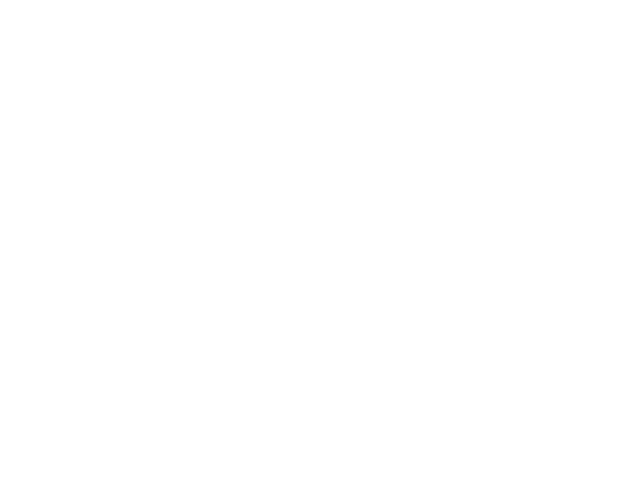

<IPython.core.display.Javascript object>


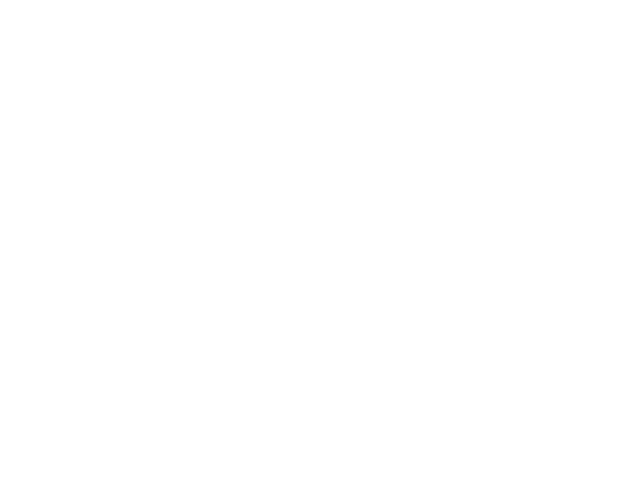

<IPython.core.display.Javascript object>


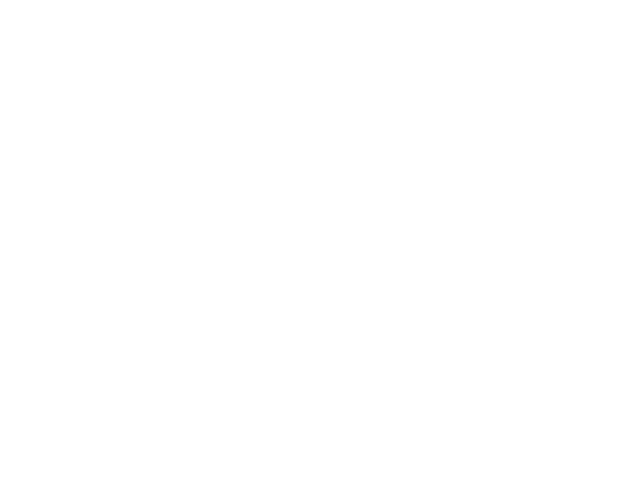

<IPython.core.display.Javascript object>


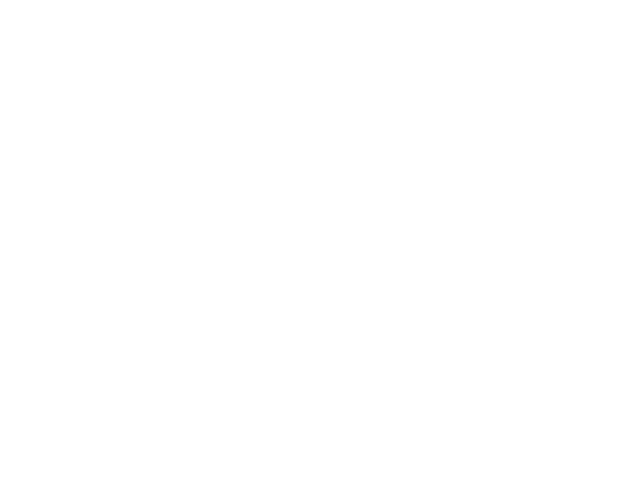

<IPython.core.display.Javascript object>


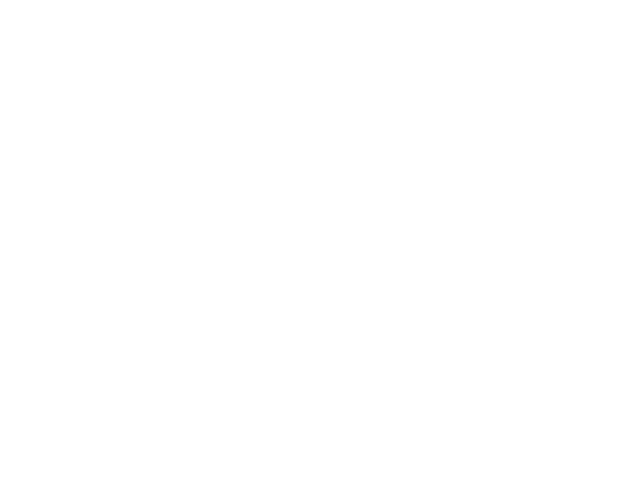

<IPython.core.display.Javascript object>


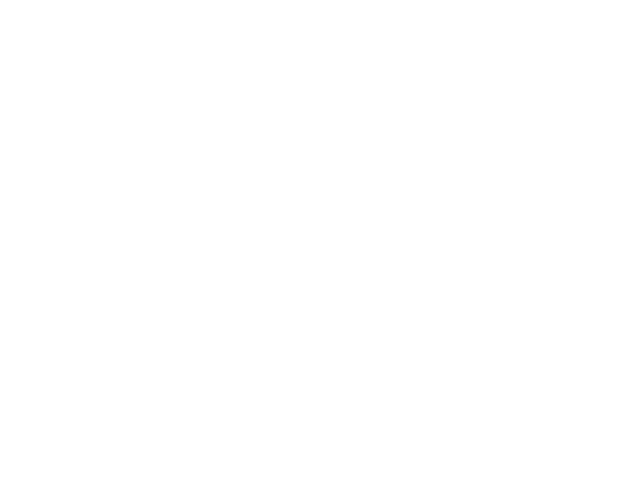

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned


<IPython.core.display.Javascript object>


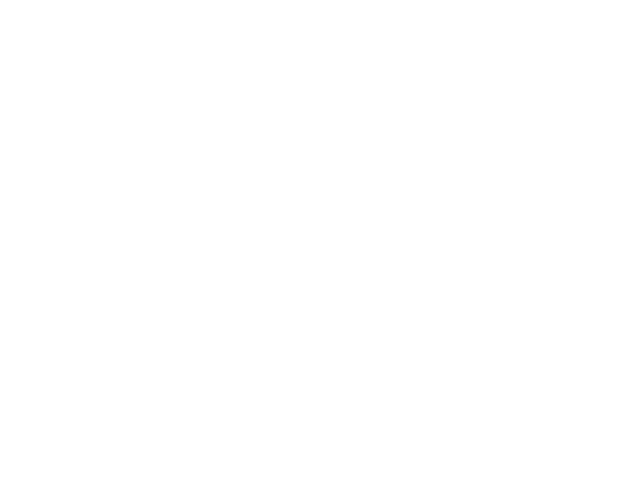

<IPython.core.display.Javascript object>


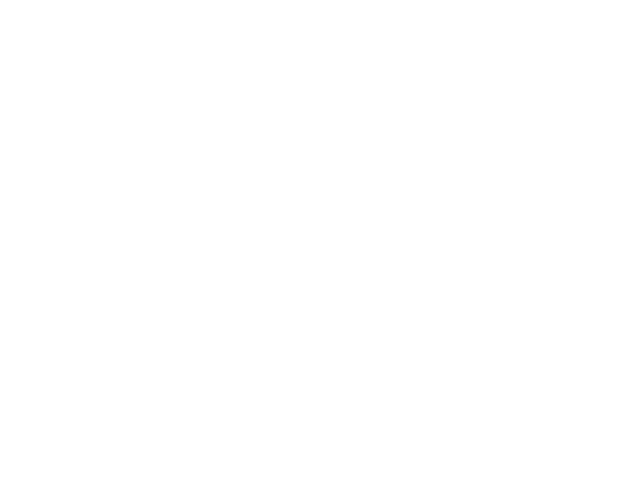

<IPython.core.display.Javascript object>


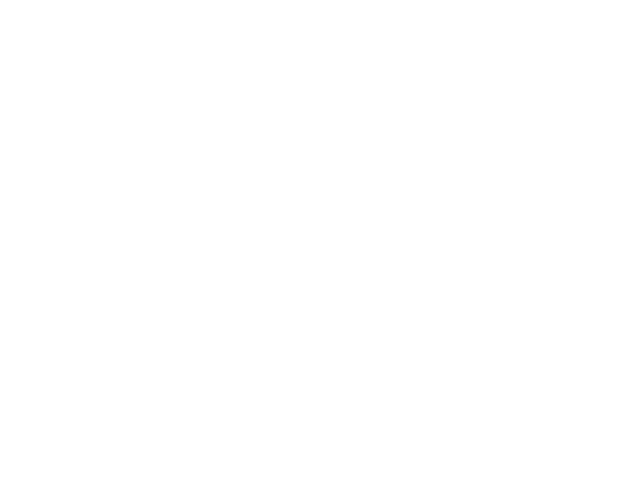

<IPython.core.display.Javascript object>


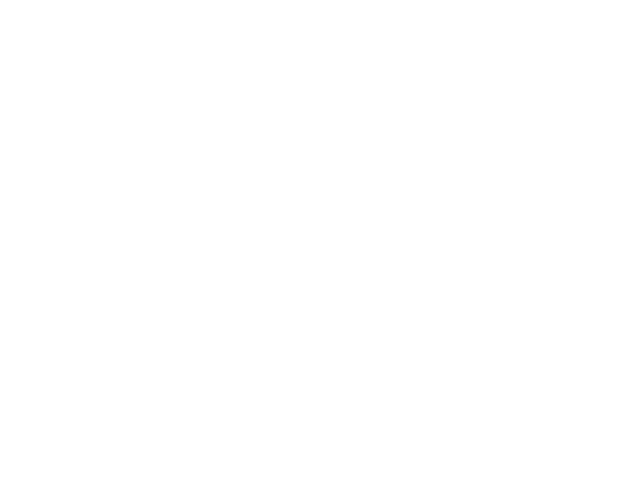

<IPython.core.display.Javascript object>


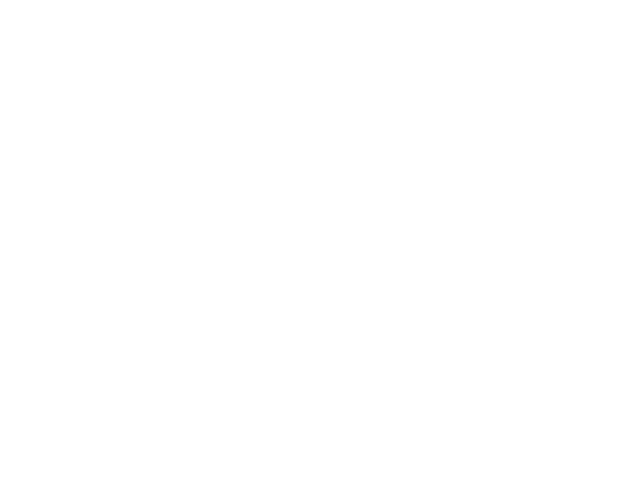

<IPython.core.display.Javascript object>


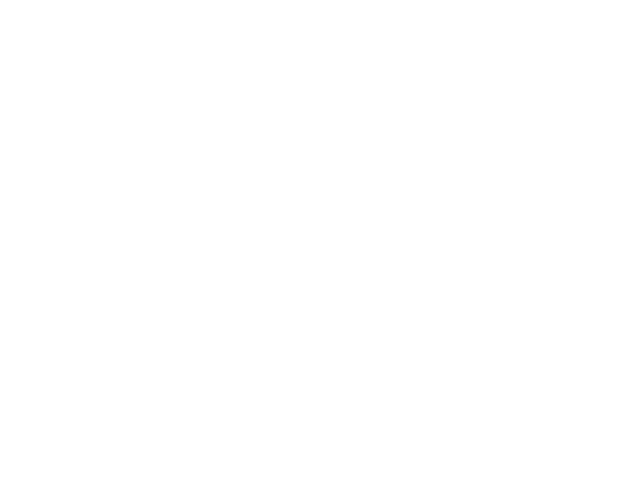

<IPython.core.display.Javascript object>


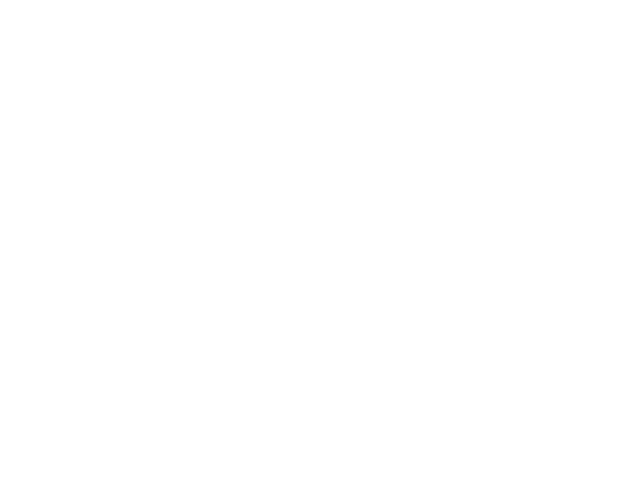

<IPython.core.display.Javascript object>


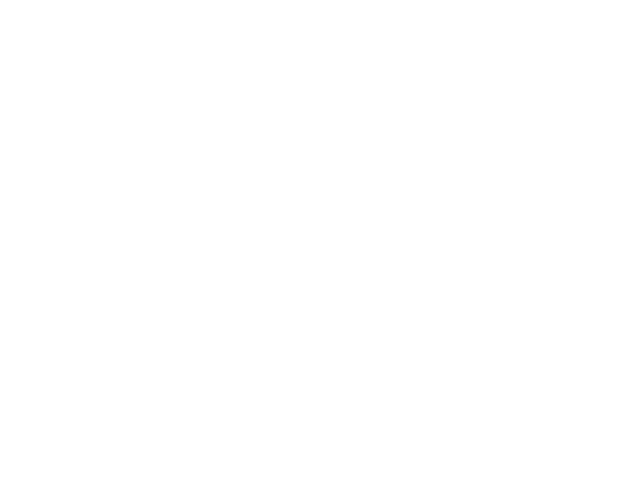

<IPython.core.display.Javascript object>


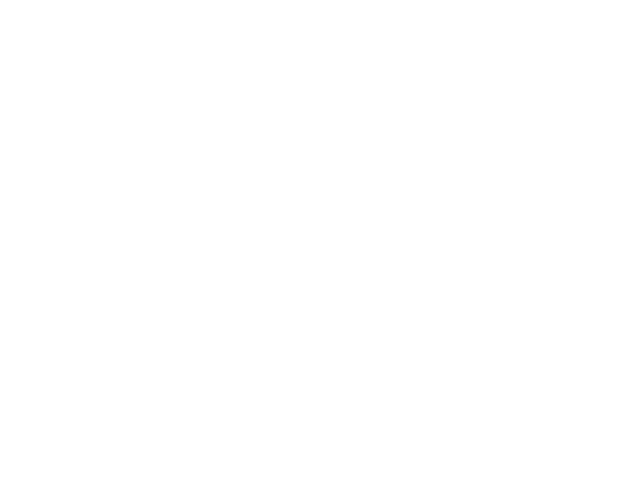

<IPython.core.display.Javascript object>


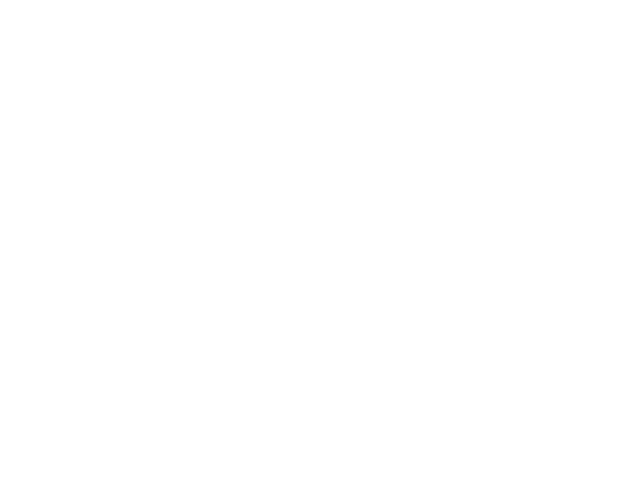

<IPython.core.display.Javascript object>


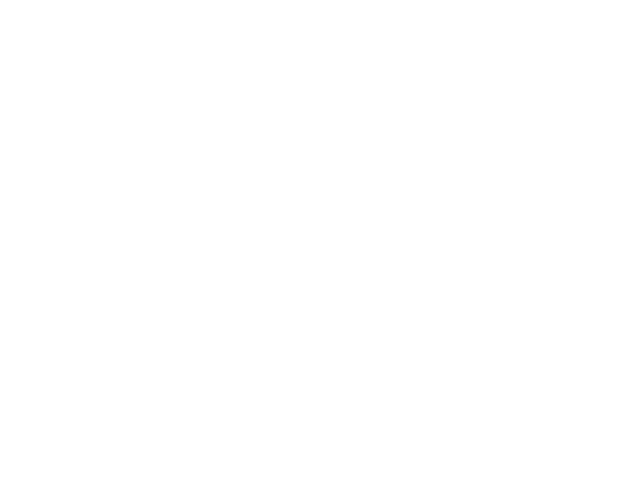

<IPython.core.display.Javascript object>


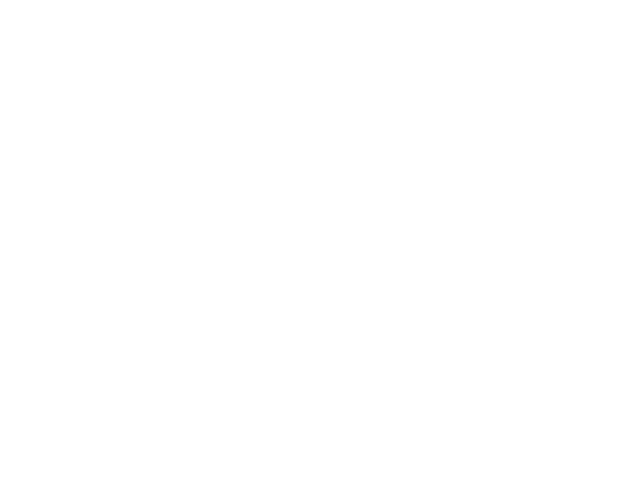

<IPython.core.display.Javascript object>


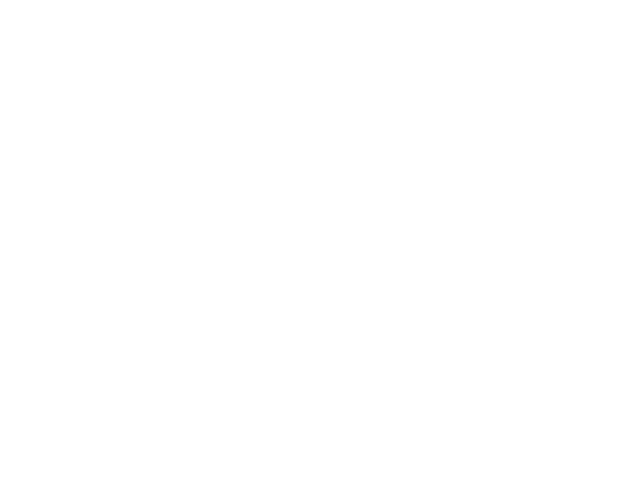

<IPython.core.display.Javascript object>


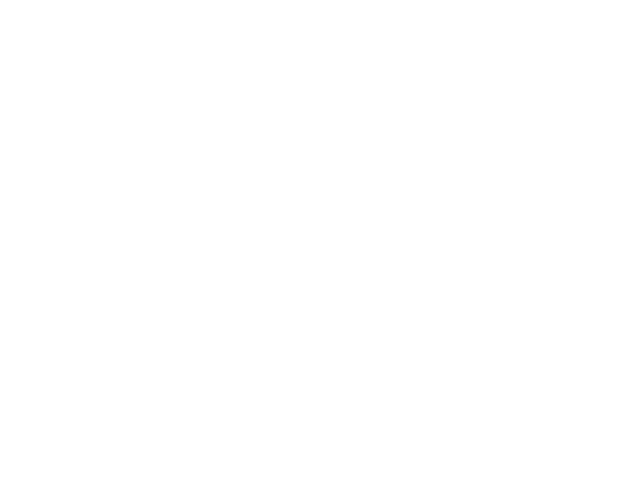

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned


<IPython.core.display.Javascript object>


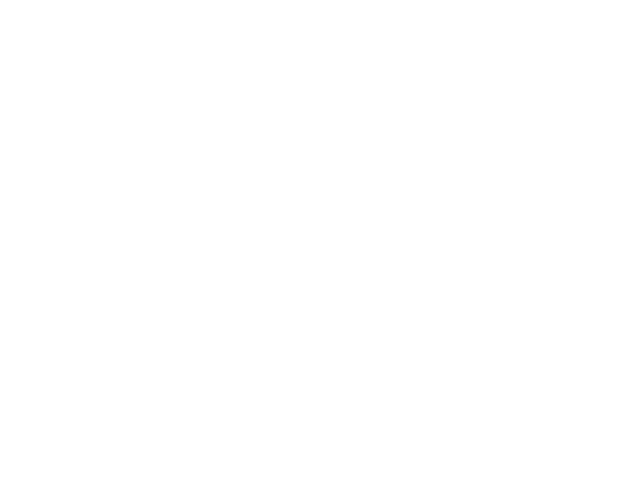

<IPython.core.display.Javascript object>


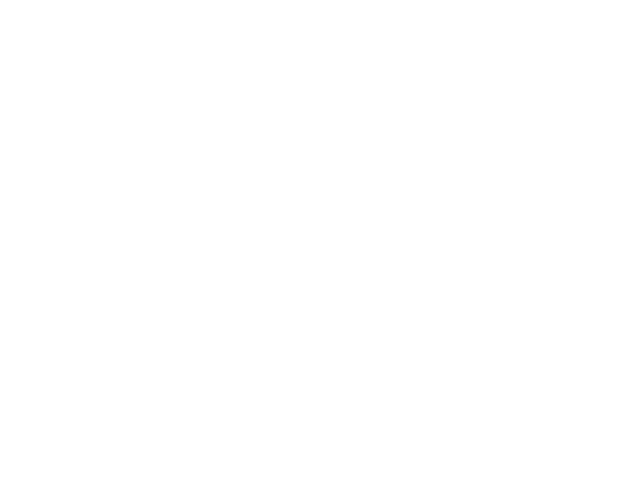

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned


IndexError: list index out of range

In [240]:
for n_fish in range(17,len(list_files)):
    path_fish = list(list_files[n_fish].glob("*10000.h5"))[0]
    data = fl.load(path_fish)['df_with_missing']
    filt_size = 8
    th_l = .7
    samp_freq = 80 #Hz
    x_ = np.array(data[()])[:,0]
    y_ = np.array(data[()])[:,1]
    x_[np.array(data[()])[:,-1]<th_l] = np.nan
    y_[np.array(data[()])[:,-1]<th_l] = np.nan
    x_data = interpolate_nans(generic_filter(x_,np.nanmean,filt_size))
    y_data = interpolate_nans(generic_filter(y_,np.nanmean,filt_size))
    velocity = generic_filter(np.sqrt(np.diff(x_data)**2 + np.diff(y_data)**2) / (1/80),np.nanmean,filt_size)
    plt.figure()
    plt.scatter(x_data,y_data,lw=.5,alpha=.3, c=np.array(data[()])[:,-1],vmin=0,vmax=1)
    plt.title(str(path_fish))
    plt.show()
    bouts_extracted, _= extract_segments_above_threshold(velocity,
                                                     threshold=30, min_length=2, min_between=5, break_segment_on_nan=True)
    plt.figure()
    plt.plot(velocity)
    plt.scatter(bouts_extracted[:,0],[5]*bouts_extracted.shape[0])
    plt.scatter(bouts_extracted[:,1],[5]*bouts_extracted.shape[0])
    plt.show()

    thetas = extract_theta_bouts(bouts_extracted, x_data, y_data,tp_vect=3)

    df_out = pd.DataFrame({"tp_start":bouts_extracted[:,0],
                           "tp_end":bouts_extracted[:,1],
                            "x_start":x_data[bouts_extracted[:,0]],
                            "y_start": y_data[bouts_extracted[:,0]],
                            "x_end":x_data[bouts_extracted[:,1]],
                            "y_end":x_data[bouts_extracted[:,1]],
                            "theta":thetas})
    fl.save(path_fish.parent/"extracted_bouts.h5",df_out)

<IPython.core.display.Javascript object>


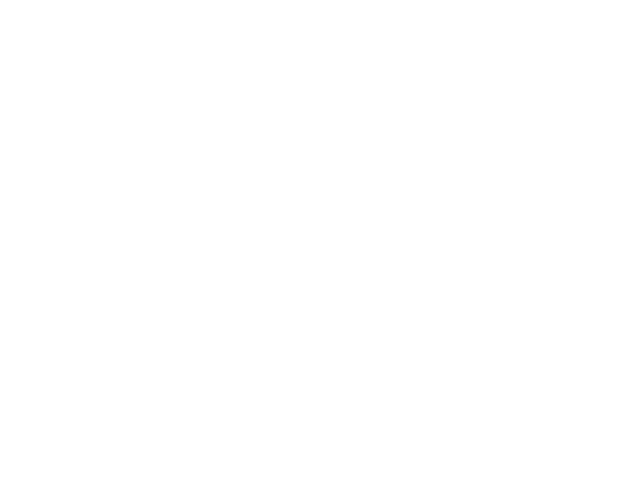

In [237]:
plt.figure()
plt.plot(x_data,y_data,lw=.5,alpha=.3)
plt.scatter(x_data[bouts_extracted[:,0]],
            y_data[bouts_extracted[:,0]],c=abs(np.array(thetas)),cmap="afmhot")
plt.show()
plt.show()

In [286]:
list_files = list(Path(r"\\FUNES\Shared\experiments\virtual_gradients_experiments\behavior_poa_ablation").glob("*_f*"))


In [287]:
list_files

[WindowsPath('//FUNES/Shared/experiments/virtual_gradients_experiments/behavior_poa_ablation/020822_f4_poa_33left'),
 WindowsPath('//FUNES/Shared/experiments/virtual_gradients_experiments/behavior_poa_ablation/020822_f5_poa_33right'),
 WindowsPath('//FUNES/Shared/experiments/virtual_gradients_experiments/behavior_poa_ablation/030822_f0_ot_33right'),
 WindowsPath('//FUNES/Shared/experiments/virtual_gradients_experiments/behavior_poa_ablation/030822_f10_poa_33right'),
 WindowsPath('//FUNES/Shared/experiments/virtual_gradients_experiments/behavior_poa_ablation/030822_f11_poa_33left'),
 WindowsPath('//FUNES/Shared/experiments/virtual_gradients_experiments/behavior_poa_ablation/030822_f1_ot_33left'),
 WindowsPath('//FUNES/Shared/experiments/virtual_gradients_experiments/behavior_poa_ablation/030822_f1_poa_33left'),
 WindowsPath('//FUNES/Shared/experiments/virtual_gradients_experiments/behavior_poa_ablation/030822_f2_ot_33right'),
 WindowsPath('//FUNES/Shared/experiments/virtual_gradients_ex

In [301]:
for n_fish in range(1,len(list_files)-1):
    path_fish = list(list_files[n_fish].glob("*10000.h5"))[0]
    data = fl.load(path_fish.parent/"extracted_bouts.h5")
    t_start = data["tp_start"]/80
    t_end = data["tp_end"]/80
    y_start = (data["y_start"]*.1)-2
    if str(path_fish.parent)[-2] == "h":
        flip_x_start = abs(((data["x_start"]*.1)-16.6)-200)
        flip_x_end = abs(((data["x_end"]*.1)-16.6)-200)

    else:
        flip_x_start = (data["x_start"]*.1)-16.6
        flip_x_end = (data["x_end"]*.1)-16.6

    df_out = pd.DataFrame({"t_start":t_start,
                               "t_end":t_end,
                                "flip_x_start":flip_x_start,
                           "flip_x_end":flip_x_end,
                                "y_start": y_start,
                                "theta_bout":data["theta"]})
    fl.save(path_fish.parent/"extracted_bouts_corrected.h5",df_out)

In [370]:
poa = []
ot = []
list_files = list(Path(r"\\FUNES\Shared\experiments\virtual_gradients_experiments\behavior_poa_ablation").glob("*ot*"))
for n_fish in range(len(list_files)):
    path_fish = list(list_files[n_fish].glob("*10000.h5"))[0]
    data = fl.load(path_fish.parent/"extracted_bouts_corrected.h5")
    if len(data)>0:
        ot.append(data)
    else:print("mmm")
    
list_files = list(Path(r"\\FUNES\Shared\experiments\virtual_gradients_experiments\behavior_poa_ablation").glob("*poa*"))
for n_fish in range(1,len(list_files)):
    path_fish = list(list_files[n_fish].glob("*10000.h5"))[0]
    data = fl.load(path_fish.parent/"extracted_bouts_corrected.h5")
    if len(data)>0:
        poa.append(data)
    else:print("mmm")

In [ ]:
plt.fi

In [374]:
len(list(Path(r"\\FUNES\Shared\experiments\virtual_gradients_experiments\behavior_poa_ablation").glob("*ot*")))

20

In [378]:
list(Path(r"\\FUNES\Shared\experiments\virtual_gradients_experiments\behavior_poa_ablation").glob("*poa*"))

[WindowsPath('//FUNES/Shared/experiments/virtual_gradients_experiments/behavior_poa_ablation/020822_f4_poa_33left'),
 WindowsPath('//FUNES/Shared/experiments/virtual_gradients_experiments/behavior_poa_ablation/020822_f5_poa_33right'),
 WindowsPath('//FUNES/Shared/experiments/virtual_gradients_experiments/behavior_poa_ablation/030822_f10_poa_33right'),
 WindowsPath('//FUNES/Shared/experiments/virtual_gradients_experiments/behavior_poa_ablation/030822_f11_poa_33left'),
 WindowsPath('//FUNES/Shared/experiments/virtual_gradients_experiments/behavior_poa_ablation/030822_f1_poa_33left'),
 WindowsPath('//FUNES/Shared/experiments/virtual_gradients_experiments/behavior_poa_ablation/030822_f2_poa_33right'),
 WindowsPath('//FUNES/Shared/experiments/virtual_gradients_experiments/behavior_poa_ablation/030822_f6_poa_33left'),
 WindowsPath('//FUNES/Shared/experiments/virtual_gradients_experiments/behavior_poa_ablation/030822_f7_poa_33right'),
 WindowsPath('//FUNES/Shared/experiments/virtual_gradients

In [ ]:
plt.figure()
# plt.hist(pd.concat(ot)["flip_x_start"],alpha=.3)
plt.hist(poa[1]["theta_bout"],alpha=.3)

plt.show()

In [371]:
df_out = {"poa":poa,
        "ot":ot}
fl.save(r"\\Funes\Shared\experiments\virtual_gradients_experiments\data_2p_ablations.h5",df_out)

In [315]:
len(ot)

16